### For turing users

In [1]:
# !pip install discrete-optimization-extension --extra-index-url https://pip.dsrg.fh-zwickau.de
# !pip install bias-variance-agent=='0.1.0.dev1' --extra-index-url https://pip.dsrg.fh-zwickau.de
# !pip install imblearn
# !pip install jutils with pip install --extra-index-url https://pip.dsrg.fh-zwickau.de

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from collections import defaultdict

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, SCORERS
from sklearn.tree import DecisionTreeClassifier

from imblearn.over_sampling import SMOTE

import biva
import dope
from biva.agent import Agent, Mode

# https://doc.dsrg.fh-zwickau.de/jutils/devel/
from jutils.plot import Plot
from jutils.html import HBox

import warnings
warnings.filterwarnings("ignore")

In [2]:
from biva.utils import check_gpu, check_tf_version, set_gpu

In [3]:
check_tf_version()
check_gpu()

TensorFlow Version: 2.3.1
Default GPU Device: /device:GPU:0


True

In [4]:
set_gpu(per_process_gpu_memory_fraction=0.5)

<a id="content"></a>

## Table of Contents

* [Data](#data)
* [Data preprocessing](#data_preprocess)
* [General principle](#general)
* [Usage](#usage)
    * [Define Agent](#definition)
    * [Define config](#config)
    * [Train](#train)
    * [Optimize](#optimize)
* [Features](#features)
    * [Data partitions](#data_partitions)
    * [Customize fit](#fit)
    * [Preprocessing optimization](#preprocessing)
    * [Custom evaluation](#evaluation)
    * [Customize scan](#Customize)
* [Examples](#examples)
* [Unbalanced data](#Unbalanced_data)

<a id="install"></a>
## [Data](#content) 

<font color=green> **The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).**</font>

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).



**Data Set Information:**

You will find the data in `data/bank-full.csv`. 

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Attribute Information:**

`Input variables:`
#### bank client data:
+ 1 - age (numeric)
+ 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
+ 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
+ 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
+ 5 - default: has credit in default? (categorical: 'no','yes','unknown')
+ 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
+ 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

+ 8 - contact: contact communication type (categorical: 'cellular','telephone')
+ 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
+ 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
+ 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

####  other attributes:
+ 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
+ 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
+ 14 - previous: number of contacts performed before this campaign and for this client (numeric)
+ 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes

+ 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
+ 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
+ 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
+ 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
+ 20 - nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

+ 21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




<a id="data_preprocess"></a>
## [Data preprocessing](#content) 

In [5]:
from biva.utils import get_categorical_cols, get_numerical_cols

In [6]:
RND_SEED = 0
data = pd.read_csv('../../data/bank-full.csv', sep= ';')
# data = pd.read_csv('../datasets/lecture/bank-full.csv', sep= ';')
# data = pd.read_csv('../datasets/lecture/bank-additional-full.csv', sep=';')

# Datatype changes
data['day'] = data['day'].astype(str)

categorical = get_categorical_cols(data)
numerical = get_numerical_cols(data)
print(f'categorical cols: {categorical}')
print(f'  numerical cols: {numerical}')

# Encoding the variables
label_encoder = defaultdict(LabelEncoder)
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

df = data.copy()
df[categorical] = data[categorical].apply(lambda x: label_encoder[x.name].fit_transform(x))
df[numerical] = mm_scaler.fit_transform(df[numerical])
df["balance"] = std_scaler.fit_transform(df[["balance"]])

categorical.remove('y')

X = df.drop("y", 1)
y = df.y

categorical cols: ['month', 'housing', 'y', 'default', 'contact', 'job', 'education', 'marital', 'loan', 'poutcome', 'day']
  numerical cols: ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0.519481,4,1,2,0,0.256419,1,0,2,26,8,0.053070,0.0,0.0,0.0,3,0
1,0.337662,9,2,1,0,-0.437895,1,0,2,26,8,0.030704,0.0,0.0,0.0,3,0
2,0.194805,2,1,1,0,-0.446762,1,1,2,26,8,0.015453,0.0,0.0,0.0,3,0
3,0.376623,1,1,3,0,0.047205,1,0,2,26,8,0.018707,0.0,0.0,0.0,3,0
4,0.194805,11,2,3,0,-0.447091,0,0,2,26,8,0.040260,0.0,0.0,0.0,3,0


<a id="general"></a>
# [General principle](#content) 

```python
from biva.agent import Agent

def build_model(config):
    # ... Model creation using dictionary with hyperparams config 
    return model

def fit_func(model, config, x_train, y_train, validation_data, **kwargs):
    # config - optimizible hyperparams
    # kwargs - other attrs for fit passed from train_model_on, optional
    result = model.fit(x_train, y_train, validation_data, attr1=config['attr1'], attr2=kwargs['attr2'])
    bias, variance = result['bias'], result['variance']
    return bias, variance
    
def preprocess(config, *data):
    # X and Y variables retrieval
    # Preprocessing steps with optimizible params like different thresholds for outlier detection ect.
    x, y = df.drop("y", 1), df.y
    return x, y

# Instantiate object and off we go
agnt = Agent(X, Y, preprocessing=preprocess, build_model=build_model, fit_func=fit_func)

# train model
agnt.train_model_on(**kwargs)

# optimize
agnt.scan('acs', **kwargs)
```

<a id="usage"></a>
# [1. Usage](#content) 

#### XGB example

In [8]:
from biva.agent import Agent

In [9]:
from xgboost import XGBClassifier
    
def build_model_xgb(config):
    model = XGBClassifier(**config, random_state=RND_SEED, verbosity=0)
    return model

<a id="definition"></a>
## [1.1 Define Agent](#content) with `build_model` attibute and data.

In case of sklearn models and simple keras models this is pretty much everything we need to get going.</span>

In [10]:
agnt_xgb = Agent(X, y, build_model=build_model_xgb)

<a id="config"></a>
## [1.2 Define config](#content) dictionary that cointains hyperparameters of our model.

`config` is always passed to `build_model` function

In [11]:
config_xgb = {
    'objective': 'binary:logistic', 'tree_method':'gpu_hist', 'use_label_encoder': False
}

<a id="train"></a>
## [1.3 Train](#content) 

***train_model_on*** method is used to train and validate model on specific data partitions. <br>
It can be used to train model using certain model `config` to see the effect of different hyperparameters on performance or just to estimate current performance. <p>

In [15]:
result, model = agnt_xgb.train_model_on(config_xgb)

Training on 40689 samples, testing on 4522 samples.
Training session: 1  | loss: 9.5313e-01 | val_loss: 9.0226e-01**


<a id="optimize"></a>
## [1.4 Optimize](#content) with *scan*

**1) Define parameter space using ```dope.Mode```**

In [16]:
from dope.method import Mode
from biva.utils import format_parameter_space

subsample = np.linspace(0, 1, 9)
params = [
    Mode('n_estimators', values=[50, 200], mode_optimizer="gridsearch"),
    Mode('gamma',        values=[0, 1],    mode_optimizer="bayessearch"),
    Mode('subsample',    values=subsample, mode_optimizer="randomsearch", random_samples=2),
]

print(format_parameter_space(params))

'n_estimators' : [50, 200] (2), 
'gamma'        : [0, 1] (2), 
'subsample'    : [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ] (9)
Total number of grid cofigurations: 3.60e+01 | 36
Total number of acs  cofigurations: 1.30e+01 | 13


**2) Call ```Agent().scan()``` and specify search type `optimizer` of your choice.**

Different optimizers require specific arguments, but error message will let you know if somethibng is missing. For more info see `scan` and `dope` docs.

In [17]:
%%time
variance, bconf, model = agnt_xgb.scan('acs', parameter_space=params, config=config_xgb, strategy='max')

"iterations" positional argument is missing. Using default value: 1
"order" positional argument is missing. Using default order: ['n_estimators', 'gamma', 'subsample']

acs
# Iteration: 1

GridSearch for Hyperparameter: n_estimators
Current configuration: {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'use_label_encoder': False, 'n_estimators': 50, 'gamma': 0, 'subsample': 0.000000e+00}
 Variance: -8.834574e-01, Bias: -8.834574e-01, HyperParams: {'n_estimators': 50}, Time: 0:00:01
 Variance: -8.834575e-01, Bias: -8.834574e-01, HyperParams: {'n_estimators': 200}, Time: 0:00:03
Max. Variance: -8.834575e-01, Best HyperParams: {'n_estimators': 200}, Time: 0:00:05

BayesSearch for Hyperparameter: gamma
Current configuration: {'objective': 'binary:logistic', 'tree_method': 'gpu_hist', 'use_label_encoder': False, 'n_estimators': 200, 'gamma': 0, 'subsample': 0.000000e+00}
 Variance: -8.834574e-01, Bias: -8.834574e-01, HyperParams: {'gamma': 4.750015e-01}, Time: 0:00:03
 Variance:

`bconf` contains your best hyperparameters

<a id="features"></a>
# [2. Features](#content)

<a id="data_partitions"></a>
##  2.1 You can use different [data partitions](#content) for training and scanning

by specifying `training_mode` or `evaluation_mode` argument.

<br>
<img src="../images/data_partitions.png" alt="Data partitions" width="500" >

***Data partition attributes:***

    train_data: Train data. Usually 80-90% of entire data.
                Used to train or evaluate model.
    train_y:    Train target data. (Might not be present)
    train_xy:   a tuple (train_data, train_y)

    test_data:  Test data. Data that model has never seen during training.
                Used for final model testing.
    test_y:     Test target data.
    test_xy:    a tuple (test_data, test_y)
    
    
    val_train_data:  Train data. 80-90% of train_data.
    val_train_y:     Train target data. 80-90% of train_y.
    val_train_xy:    a tuple (val_train_data, val_train_y)

    val_data:  Validation data. 10-20%(val_split) of train_data.
    val_y:     Validation target data. 10-20% of train_y.
    val_xy:    a tuple (val_data, val_y)

* Final model performance can be obtained by calling train model on the full data using ```training_mode='full'```

In [18]:
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='full')
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='test')
res, model = agnt_xgb.train_model_on(config_xgb, data_partitions='val')

Training on 45211 samples.
Training session: 1  | loss: 9.6627e-01**
Training on 40689 samples, testing on 4522 samples.
Training session: 1  | loss: 9.7100e-01 | val_loss: 8.9142e-01**
Training on 36620 samples, testing on 4069 samples.
Training session: 1  | loss: 9.7179e-01 | val_loss: 9.6510e-01**


In [19]:
bias, var, model = agnt_xgb.eval_func(config_xgb, evaluation_mode='full')
print(f'bias: {bias:.3e}, var: {var:.3e}')

bias, var, model = agnt_xgb.eval_func(config_xgb, evaluation_mode='test')
print(f'bias: {bias:.3e}, var: {var:.3e}')

bias, var, model = agnt_xgb.eval_func(config_xgb, evaluation_mode='val')
print(f'bias: {bias:.3e}, var: {var:.3e}')

bias: 9.770e-01, var: 9.010e-01
bias: 9.765e-01, var: 9.020e-01
bias: 9.764e-01, var: 9.019e-01


<a id="fit"></a>
## 2.2 Customize [fit](#content)  function

In [20]:
def loss_(true, pred, thresh=5/7):
    pred_label = np.where(pred > 5/7, 1, 0)  
    loss = np.int16((true==1)&(pred_label==0)) * 5 * (1 - pred)\
        + np.int16((true==0)&(pred_label==1)) * 25 * pred\
        + np.int16((true==1)&(pred_label==1)) * (-5) * pred
    return np.sum(loss)

def get_loss(model, data, thresh=5/7):
    y_pred = model.predict_proba(data[0])[:, 1]
    return loss_(data[1], y_pred)

# Fit function must take following arguments and return a tuple (bias, variance)
def fit(model, config, train_data, test_data, **kwargs):
    try:
        model.fit(*train_data)
    except ValueError:
        return np.inf, np.inf
    
    loss = get_loss(model, train_data)
    if test_data is not None:
        val_loss = get_loss(model, test_data)
        return loss, val_loss
    else:
        return loss, None

In [21]:
agnt_xgb = Agent(X, y, build_model=build_model_xgb, fit_func=fit)
result, model = agnt_xgb.train_model_on(config_xgb, data_partitions='test')

Training on 40689 samples, testing on 4522 samples.
Training session: 1  | loss: -5.9273e+03 | val_loss: 2.1971e+03**


<a id="preprocessing"></a>
## 2.3 Optimize parameters for [preprocessing step](#content).

In [22]:
pdays_contacted = data.pdays[data.pdays != -1].to_frame()
pdays_contacted.hist(bins=20)

std_ = pdays_contacted.describe().loc['std']

HBox( [ Plot(), pdays_contacted.describe() ], css = { 'height': '20em', 'column-gap': '1em' } )

,pdays
count,8257.000000
mean,224.577692
std,115.344035
min,1.000000
25%,133.000000
50%,194.000000
75%,327.000000
max,871.000000


In [23]:
print(categorical)

# The number of attributes you need to pass after `config` depends on how many data arguments you pass to the Agent()
def preprocessing(config: dict, x, y):
    x = x.copy()  # to prevent change of values in the initial dataset
    try:
        if config['one_hot_encode']:        
            x = pd.get_dummies(x, columns=categorical)
    except KeyError:
        pass
    try:
        ##### Modell recall as an inverse on the pdays (number of days that passed by after the client was last contacted)
        if config['new_features']:
            x["recall"] = x.pdays.apply(lambda el: 0 if (el == -1) or (el == 0) else 1 / el)
            x['attention'] = x.duration * x.campaign
            x['recognition'] = x.attention * x.recall
            x['importance'] = x.recognition * x.balance
    except KeyError:
        pass
    return x, y


build_model_xgb = lambda x: XGBClassifier(**x, verbosity=0)

# Not
agnt = Agent(X, y, build_model=build_model_xgb, preprocessing=preprocessing)

['loan', 'month', 'marital', 'default', 'day', 'poutcome', 'education', 'job', 'contact', 'housing']


### OR

In [24]:
def preprocessing(config: dict, df):
    y = df.y
    x = df.iloc[:, :-1]
        
    try:
        if config['one_hot_encode']:        
            x = pd.get_dummies(x, columns=categorical)
    except KeyError:
        pass
    try:
        ##### Modell recall as an inverse on the pdays (number of days that passed by after the client was last contacted)
        if config['new_features']:
            x["recall"] = x.pdays.apply(lambda el: 0 if (el == -1) or (el == 0) else 1 / el)
            x['attention'] = x.duration * x.campaign
            x['recognition'] = x.attention * x.recall
            x['importance'] = x.recognition * x.balance
    except KeyError:
        pass
    return x, y

agnt = Agent(df, build_model=build_model_xgb, preprocessing=preprocessing)

### Base case: all preprocessing keys are set to False

In [25]:
config_xgb = {
    'n_estimators': 128, 'subsample': 1.0, 'learning_rate': 0.2, 
    'min_child_weight': 1, 'max_depth': 4, 'gamma': 0.9, 'colsample_bytree': 0.6,
    'one_hot_encode': False,
    'new_features': False,
}

bias, var, model = agnt.eval_model_cv(config_xgb, training_mode='test', print_sessions=True)

Training on 40689 samples.
Training session: 1  | loss: 9.2691e-01 | val_loss: 9.0292e-01
Training session: 2  | loss: 9.2489e-01 | val_loss: 9.1128e-01
Training session: 3  | loss: 9.2354e-01 | val_loss: 9.0772e-01
Training session: 4  | loss: 9.2467e-01 | val_loss: 9.0526e-01
Training session: 5  | loss: 9.2440e-01 | val_loss: 9.0771e-01
--------------------------------------------------------------
Average values:      |       9.2488e-01 |           9.0698e-01


In [26]:
from dope.method import Mode

params = [
    Mode('one_hot_encode', [1, 0]),
    Mode('new_features',   [1, 0]),
]

var, conf, model = agnt.scan('grid', parameter_space=params, config=config_xgb, strategy='max')


GridSearch for Hyperparameter: one_hot_encode, new_features
Current configuration: {'n_estimators': 128, 'subsample': 1.000000e+00, 'learning_rate': 2.000000e-01, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 9.000000e-01, 'colsample_bytree': 6.000000e-01, 'one_hot_encode': False, 'new_features': False}
 Variance: -9.073705e-01, Bias: -9.257539e-01, HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:07
 Variance: -9.073705e-01, Bias: -9.252931e-01, HyperParams: {'one_hot_encode': 1, 'new_features': 0}, Time: 0:00:07
 Variance: -9.074197e-01, Bias: -9.259628e-01, HyperParams: {'one_hot_encode': 0, 'new_features': 1}, Time: 0:00:04
 Variance: -9.075426e-01, Bias: -9.242854e-01, HyperParams: {'one_hot_encode': 0, 'new_features': 0}, Time: 0:00:04
Max. Variance: -9.075426e-01, Best HyperParams: {'one_hot_encode': 0, 'new_features': 0}, Time: 0:00:24

Best config: {'n_estimators': 128, 'subsample': 1.0, 'learning_rate': 0.2, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 

<a id="evaluation"></a>
## 2.4 Define [custom evaluation](#content) methods. However you should keep in mind that you need to pass the data you want to use for evaluation too.

In [27]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=RND_SEED)

def eval_xgb(config, cv=5, scoring='roc_auc'):
    model = build_model_xgb(config)
    cv_results = cross_validate(model, x_train, y_train, cv=cv, n_jobs=-1, scoring=scoring, return_train_score=True)
    
    # Here we use the worst loss of all partitions for example
    return -(cv_results['train_score'].min()), -(cv_results['test_score'].min()), model

In [28]:
var, conf, model = agnt_xgb.scan('random', parameter_space=params, eval_func=eval_xgb, random_samples=2)
var, conf


RandomSearch for Hyperparameter: one_hot_encode, new_features
Current configuration: {'one_hot_encode': 1, 'new_features': 1}
 Variance: -9.207003e-01, Bias: -9.798107e-01, HyperParams: {'one_hot_encode': 0, 'new_features': 0}, Time: 0:00:05
 Variance: -9.207003e-01, Bias: -9.798107e-01, HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:05
Min. Variance: -9.207003e-01, Best HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:11

Best config: {'one_hot_encode': 1, 'new_features': 1}


(-0.9207003339269976, {'one_hot_encode': 1, 'new_features': 1})

<a id="Customize"></a>
##  2.5 [Customize](#content) your scan: 
* maximize or minimize target value with `strategy` argument
* select target value for optimization with `target`: {'bias', 'variance'}
* different metrics with `scoring` argument for model evaluation (sklearn models).
* `early_preprocessing` argument is used to specify when to use preprocessing on data. 
   `True` executes preprocessing function before data splitting in complementary partitions for cross validation, `False` - after, just before fit_func 
* customize outuput with `output_names` argument. See more in scan docstring


<font size=3>Agent uses default scoring parameter for particular model. This is `accurasy` for xgb, for example.<br></br>
    See available metrics for sklearn models [here](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules).</span>


In [29]:
res, model = agnt_xgb.train_model_on(config_xgb, training_mode='test', scoring='roc_auc')

Training on 40689 samples, testing on 4522 samples.
Training session: 1  | roc_auc: 1.0066e+04 | val_roc_auc: 1.5606e+03**


In [30]:
out_names = {
    "mode_var": "Hyperparameter",
    "pivot_point": "Current config",
    "refer_val": "neg Acc",
    "target_val": "neg Val Acc",
    "mode_arg": "HyperParams",
    "minimum": "Best config",
}

_, _, _ = agnt_xgb.scan('random', parameter_space=params, random_samples=2, 
                        scoring='roc_auc', strategy='max', 
                        output_names=out_names)


RandomSearch for Hyperparameter: one_hot_encode, new_features
Current config: {'one_hot_encode': 1, 'new_features': 1}
 neg Val Acc: -3.303422e+03, neg Acc: 4.231432e+02, HyperParams: {'one_hot_encode': 0, 'new_features': 1}, Time: 0:00:06
 neg Val Acc: -3.188046e+03, neg Acc: 3.102644e+02, HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:06
Max. Variance: -3.303422e+03, Best HyperParams: {'one_hot_encode': 1, 'new_features': 1}, Time: 0:00:12

Best config: {'one_hot_encode': 1, 'new_features': 1}


<a id="examples"></a>
# [3. Examples](#content).

### Lets say we want to train model on resampled data and test on original data

In [13]:
# Instanciate Agent as a data_container object to split the data
data_container = Agent(X, y, val_split=0.2, random_seed=RND_SEED)

# Prepare original data
train_xy = data_container.train_xy
test_xy = data_container.test_xy

print(f'{train_xy[0].shape[0]} train samples')
print(f'{test_xy[0].shape[0]} test samples')

# Resampling
smote = SMOTE(random_state=RND_SEED)
X_res, y_res = smote.fit_resample(*train_xy)

print(f"#Yes: {sum(y_res)} | #No: {sum(~y_res+2)}")

36168 train samples
9043 test samples
#Yes: 31942 | #No: 31942


In [16]:
from xgboost import XGBClassifier

def build_model_xgb(config):
    return XGBClassifier(**config, random_state=RND_SEED)

agnt = Agent(*train_xy, build_model=build_model_xgb, random_seed=RND_SEED)

In [18]:
config = {'n_estimators':100, 'subsample': 1.0, 'learning_rate': 0.2, 'min_child_weight': 10, 
          'max_depth': 6, 'gamma': 1, 'colsample_bytree': 0.6, 'eval_metric': 'logloss'}

res, model = agnt.train_model_on(config, validation_mode='full', test_data=test_xy)

Training on 32551 samples, testing on 9043 samples.
Training session: 1  | loss: 9.3358e-01 | val_loss: 8.9981e-01**


## Keras

We need to create X with one-hot-encoded categorical variables

In [19]:
X_res_enc = pd.get_dummies(X_res, columns=categorical)
X_res_enc.shape

(63884, 81)

In [20]:
from biva.utils.plotters import plot_epochs

In [21]:
metrics=['acc']

def build_model_keras(config):
    model = Sequential()
    model.add(Dense(config['denseLayer1'], activation=config['actFuncL1'], input_dim=X_res_enc.shape[1]))
    model.add(Dense(config['denseLayer2'], activation=config['actFuncL2']))
    model.add(Flatten())
    model.add(Dense(1, activation=config['actFuncLast']))
    
    lm = tf.keras.optimizers.Adadelta(lr=config['lr'])
    model.compile(loss="binary_crossentropy", optimizer=lm, metrics=metrics)
    return model

config_keras = {
    'denseLayer1': 256, 'actFuncL1': 'elu',
    'denseLayer2': 256, 'actFuncL2': 'elu',
    'actFuncLast': 'sigmoid', 
    'epochs':5, 'batch_size': 32,
    'lr': 0.01, 'beta_1': 0.85}

In [22]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0005, patience=4)]
agent = Agent(X_res_enc, y_res, build_model=build_model_keras, callbacks=callbacks)

Training on 57495 samples, testing on 6389 samples.
Training session: 1  | loss: 3.1870e-01 | val_loss: 3.2270e-01**
Training session: 2  | loss: 3.1848e-01 | val_loss: 3.2197e-01**
Training session: 3  | loss: 3.1871e-01 | val_loss: 3.2293e-01
--------------------------------------------------------------
Average values:      |       3.1863e-01 |           3.2253e-01


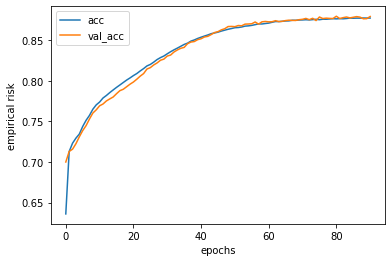

Wall time: 3min 57s


In [23]:
%%time
log, model = agent.train_model_on(config_keras, n_trainings=3, epochs=1000, batch_size=256)
plot_epochs(log, metrics)

**You can also change the metric output name in output and criterion for the training.**

In [ ]:
%%time
log, model = agent.train_model_on(config_keras, n_trainings=4, 
                                  epochs=120, batch_size=512, 
                                  criterion='variance', metric_name='mse')
plot_epochs(log)

In [ ]:
neurons = [Mode(f'denseLayer{i}', [32, 64, 128, 256]) for i in range(1, 3)]

var, bconf, model = agent.scan('acs', neurons, config_keras, iterations=1)

In [ ]:
%%time
bconf = {'denseLayer1': 256, 'actFuncL1': 'relu', 'denseLayer2': 64, 'actFuncL2': 'relu', 
         'actFuncLast': 'sigmoid', 'lr': 0.09539879737836925, 'beta_1': 0.85}

log, model = agent.train_model_on(bconf, validation_mode='test', epochs=50, batch_size=128)

In [ ]:
plot_epochs(log)

In [ ]:
plot_epochs(log, ['acc'])

## Decision Trees

In [ ]:
from sklearn.linear_model import LogisticRegression

def build_model_logregr(config):
    # Notice that I don't use random_state=RND_SEED now.
    return LogisticRegression(**config)

In [ ]:
agnt_logr = Agent(X_res, y_res, build_model=build_model_logregr)

In [ ]:
config_logregr = dict(C=0.001, penalty='l2', random_state=1)
agnt_logr.train_model_on(config_logregr, print_sessions=True)

In [ ]:
from biva.utils import dict_to_ModeList

In [ ]:
params = {"C":       np.logspace(-3,3,7), 
          "penalty": ['l2', 'None']}

params = dict_to_ModeList(params)
print(format_parameter_space(params))

In [ ]:
var, bconf_logregr, logreger, = agnt_logr.scan('random', params, random_samples=5)
bconf_logregr

Scoring parameter can be passed for any sklear model.

In [ ]:
res, model = agnt_logr.train_model_on(bconf_logregr, scoring='adjusted_rand_score')

<a id="Unbalanced_data"></a>
## [Unbalanced data](#content)

Don't forget to change input shape

In [ ]:
def build_model_keras(config):
    model = Sequential()
    model.add(Dense(config['denseLayer1'], activation=config['actFuncL1'], input_dim=X.shape[1]))
    model.add(Dense(config['denseLayer2'], activation=config['actFuncL2']))
    model.add(Flatten())
    model.add(Dense(1, activation=config['actFuncLast']))
    lm = tf.keras.optimizers.Adadelta(lr=config['lr'])
    model.compile(loss="binary_crossentropy", optimizer=lm, metrics=['acc'])
    return model

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=3)]
agent = Agent(X, y, build_model=build_model_keras, callbacks=callbacks)

In [ ]:
%%time
bconf = {'denseLayer1': 256, 'actFuncL1': 'relu', 'denseLayer2': 64, 'actFuncL2': 'relu', 
         'actFuncLast': 'sigmoid', 'epochs': 5, 'lr': 0.09539879737836925, 'beta_1': 0.85}

log, model = agent.train_model_on(bconf, n_trainings=3, validation_mode='test', criterion='variance', epochs=500, batch_size=256)

In [ ]:
from biva.utils.metrics import confusion_matrix_by_threshold
from biva.utils.plotters import plot_confusion_matrix

**Default confusion metrics (thresh=0.5)**

In [ ]:
y_pred = model.predict(agent.x_test)
y_true = agent.y_test
cmat = confusion_matrix_by_threshold(y_true, y_pred)
plot_confusion_matrix(cmat)

**Context**

* **True positive** - client subscribed a term deposit just as predicted. Income. (**maximize**)
* **False positive** - client did not subscribe to a term deposit just as predicted, so we might as well haven't wasted our time.(**maximize**)
* **False negative** - predicted that client *would not* subscribe, but he actually would! Income waste. (**minimize**)
* **False positive** - predicted that client *would* subscribe, but he didn't. Time waste.

So taken into account our group sizes and that we want to maximize icome and minimise time wasted we conclude that **tp**, **tn** and **fn** are of key importance.

In [ ]:
from biva.utils.metrics import class_metrics, class_metrics_by_threshold, get_best_thres
from biva.utils.plotters import plot_metrics_per_threshold

In [ ]:
mbt = class_metrics_by_threshold(y_true, y_pred)
mbt

**Best confusion matrix**

In [ ]:
thr, metric = get_best_thres(mbt, 'matthews_corrcoef')
thr, metric

In [ ]:
y_pred = model.predict(agent.x_test)
y_true = agent.y_test
cmat = confusion_matrix_by_threshold(y_true, y_pred, thr)
plot_confusion_matrix(cmat)

In [ ]:
plot_metrics_per_threshold(y_true, y_pred)
plt.show()

### Remarks

In [ ]:
def build_model_xgb(config):
    model = XGBClassifier(**config)
    return model

agnt_xgb = Agent(X, y, build_model=build_model_xgb, splitter=2)

In [ ]:
config_xgb = {
    'max_depth':20,
    'n_estimators':500,
    'subsample': 1.0,
    'learning_rate': 0.3,
    'min_child_weight': 1,
    'gamma': 2,
    'colsample_bytree': 1.0,
    'eval_metric': 'logloss'
}

In [ ]:
%%time
agnt_xgb.train_model_on(config_xgb)

#### You can also evaluate model performance by means of cross-validation

In [ ]:
bias, var, model = agnt_xgb.eval_model_cv_sklearn(config_xgb)
bias, var

In [ ]:
params = [
    Mode('n_estimators',     values=[100, 500, 1000]),
    Mode('max_depth',        values=np.arange(5, 21, 5)),
    Mode('learning_rate',    values=[0.001, 1.0], mode_optimizer='bayessearch', init_points=5, n_trials=20),
    Mode('gamma',            values=[0.5, 1, 2, 5, 10, 20]),
    Mode('min_child_weight', values=[1, 5, 10, 20, 40, 60]),
    Mode('subsample',        values=[0.6, 0.7, 0.8, 1.0]),
    Mode('colsample_bytree', values=[0.6, 0.8, 1.0]),
    Mode('subsample',        values=[0.8, 1.0])
]

In [ ]:
print(format_parameter_space(params))

In [ ]:
?Agent().scan